In [1]:
import fastai

In [2]:
from datasets import load_dataset
from fastai.tabular.all import *
from huggingface_hub import from_pretrained_fastai, notebook_login, push_to_hub_fastai
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [3]:
import datasets

# Suppress logs
datasets.logging.set_verbosity_error()

In [4]:
top_tagging_ds = load_dataset("dl4phys/top_tagging")

In [5]:
top_tagging_ds

DatasetDict({
    train: Dataset({
        features: ['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2', 'PX_2', 'PY_2', 'PZ_2', 'E_3', 'PX_3', 'PY_3', 'PZ_3', 'E_4', 'PX_4', 'PY_4', 'PZ_4', 'E_5', 'PX_5', 'PY_5', 'PZ_5', 'E_6', 'PX_6', 'PY_6', 'PZ_6', 'E_7', 'PX_7', 'PY_7', 'PZ_7', 'E_8', 'PX_8', 'PY_8', 'PZ_8', 'E_9', 'PX_9', 'PY_9', 'PZ_9', 'E_10', 'PX_10', 'PY_10', 'PZ_10', 'E_11', 'PX_11', 'PY_11', 'PZ_11', 'E_12', 'PX_12', 'PY_12', 'PZ_12', 'E_13', 'PX_13', 'PY_13', 'PZ_13', 'E_14', 'PX_14', 'PY_14', 'PZ_14', 'E_15', 'PX_15', 'PY_15', 'PZ_15', 'E_16', 'PX_16', 'PY_16', 'PZ_16', 'E_17', 'PX_17', 'PY_17', 'PZ_17', 'E_18', 'PX_18', 'PY_18', 'PZ_18', 'E_19', 'PX_19', 'PY_19', 'PZ_19', 'E_20', 'PX_20', 'PY_20', 'PZ_20', 'E_21', 'PX_21', 'PY_21', 'PZ_21', 'E_22', 'PX_22', 'PY_22', 'PZ_22', 'E_23', 'PX_23', 'PY_23', 'PZ_23', 'E_24', 'PX_24', 'PY_24', 'PZ_24', 'E_25', 'PX_25', 'PY_25', 'PZ_25', 'E_26', 'PX_26', 'PY_26', 'PZ_26', 'E_27', 'PX_27', 'PY_27', 'PZ_27', 'E_28'

In [6]:
top_tagging_ds["train"]

Dataset({
    features: ['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2', 'PX_2', 'PY_2', 'PZ_2', 'E_3', 'PX_3', 'PY_3', 'PZ_3', 'E_4', 'PX_4', 'PY_4', 'PZ_4', 'E_5', 'PX_5', 'PY_5', 'PZ_5', 'E_6', 'PX_6', 'PY_6', 'PZ_6', 'E_7', 'PX_7', 'PY_7', 'PZ_7', 'E_8', 'PX_8', 'PY_8', 'PZ_8', 'E_9', 'PX_9', 'PY_9', 'PZ_9', 'E_10', 'PX_10', 'PY_10', 'PZ_10', 'E_11', 'PX_11', 'PY_11', 'PZ_11', 'E_12', 'PX_12', 'PY_12', 'PZ_12', 'E_13', 'PX_13', 'PY_13', 'PZ_13', 'E_14', 'PX_14', 'PY_14', 'PZ_14', 'E_15', 'PX_15', 'PY_15', 'PZ_15', 'E_16', 'PX_16', 'PY_16', 'PZ_16', 'E_17', 'PX_17', 'PY_17', 'PZ_17', 'E_18', 'PX_18', 'PY_18', 'PZ_18', 'E_19', 'PX_19', 'PY_19', 'PZ_19', 'E_20', 'PX_20', 'PY_20', 'PZ_20', 'E_21', 'PX_21', 'PY_21', 'PZ_21', 'E_22', 'PX_22', 'PY_22', 'PZ_22', 'E_23', 'PX_23', 'PY_23', 'PZ_23', 'E_24', 'PX_24', 'PY_24', 'PZ_24', 'E_25', 'PX_25', 'PY_25', 'PZ_25', 'E_26', 'PX_26', 'PY_26', 'PZ_26', 'E_27', 'PX_27', 'PY_27', 'PZ_27', 'E_28', 'PX_28', 'PY_28', 'PZ_28', 

In [7]:
len(top_tagging_ds["train"])

1211000

In [8]:
top_tagging_ds = top_tagging_ds.remove_columns(
    ["truthE", "truthPX", "truthPY", "truthPZ", "ttv"]
)

In [9]:
# Convert output format to DataFrames
top_tagging_ds.set_format("pandas")
# Create DataFrames for the training and test splits
train_df, test_df = top_tagging_ds["train"][:], top_tagging_ds["test"][:]
# Peek at first few rows
train_df.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,PZ_197,E_198,PX_198,PY_198,PZ_198,E_199,PX_199,PY_199,PZ_199,is_signal_new
0,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [10]:
frac_of_samples = 1.0
train_df = train_df.sample(int(frac_of_samples * len(train_df)), random_state=42)

features = list(train_df.drop(columns=["is_signal_new"]).columns)
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(train_df))

dls = TabularDataLoaders.from_df(
    df=train_df,
    cont_names=features,
    y_names="is_signal_new",
    y_block=CategoryBlock,
    splits=splits,
    bs=1024,
)

In [11]:
dls.show_batch()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,PY_2,PZ_2,E_3,PX_3,PY_3,PZ_3,E_4,PX_4,PY_4,PZ_4,E_5,PX_5,PY_5,PZ_5,E_6,PX_6,PY_6,PZ_6,E_7,PX_7,PY_7,PZ_7,E_8,PX_8,PY_8,PZ_8,E_9,PX_9,PY_9,PZ_9,E_10,PX_10,PY_10,PZ_10,E_11,PX_11,PY_11,PZ_11,E_12,PX_12,PY_12,PZ_12,E_13,PX_13,PY_13,PZ_13,E_14,PX_14,PY_14,PZ_14,E_15,PX_15,PY_15,PZ_15,E_16,PX_16,PY_16,PZ_16,E_17,PX_17,PY_17,PZ_17,E_18,PX_18,PY_18,PZ_18,E_19,PX_19,PY_19,PZ_19,E_20,PX_20,PY_20,PZ_20,E_21,PX_21,PY_21,PZ_21,E_22,PX_22,PY_22,PZ_22,E_23,PX_23,PY_23,PZ_23,E_24,PX_24,PY_24,PZ_24,E_25,PX_25,PY_25,PZ_25,E_26,PX_26,PY_26,PZ_26,E_27,PX_27,PY_27,PZ_27,E_28,PX_28,PY_28,PZ_28,E_29,PX_29,PY_29,PZ_29,E_30,PX_30,PY_30,PZ_30,E_31,PX_31,PY_31,PZ_31,E_32,PX_32,PY_32,PZ_32,E_33,PX_33,PY_33,PZ_33,E_34,PX_34,PY_34,PZ_34,E_35,PX_35,PY_35,PZ_35,E_36,PX_36,PY_36,PZ_36,E_37,PX_37,PY_37,PZ_37,E_38,PX_38,PY_38,PZ_38,E_39,PX_39,PY_39,PZ_39,E_40,PX_40,PY_40,PZ_40,E_41,PX_41,PY_41,PZ_41,E_42,PX_42,PY_42,PZ_42,E_43,PX_43,PY_43,PZ_43,E_44,PX_44,PY_44,PZ_44,E_45,PX_45,PY_45,PZ_45,E_46,PX_46,PY_46,PZ_46,E_47,PX_47,PY_47,PZ_47,E_48,PX_48,PY_48,PZ_48,E_49,PX_49,PY_49,PZ_49,E_50,PX_50,PY_50,PZ_50,E_51,PX_51,PY_51,PZ_51,E_52,PX_52,PY_52,PZ_52,E_53,PX_53,PY_53,PZ_53,E_54,PX_54,PY_54,PZ_54,E_55,PX_55,PY_55,PZ_55,E_56,PX_56,PY_56,PZ_56,E_57,PX_57,PY_57,PZ_57,E_58,PX_58,PY_58,PZ_58,E_59,PX_59,PY_59,PZ_59,E_60,PX_60,PY_60,PZ_60,E_61,PX_61,PY_61,PZ_61,E_62,PX_62,PY_62,PZ_62,E_63,PX_63,PY_63,PZ_63,E_64,PX_64,PY_64,PZ_64,E_65,PX_65,PY_65,PZ_65,E_66,PX_66,PY_66,PZ_66,E_67,PX_67,PY_67,PZ_67,E_68,PX_68,PY_68,PZ_68,E_69,PX_69,PY_69,PZ_69,E_70,PX_70,PY_70,PZ_70,E_71,PX_71,PY_71,PZ_71,E_72,PX_72,PY_72,PZ_72,E_73,PX_73,PY_73,PZ_73,E_74,PX_74,PY_74,PZ_74,E_75,PX_75,PY_75,PZ_75,E_76,PX_76,PY_76,PZ_76,E_77,PX_77,PY_77,PZ_77,E_78,PX_78,PY_78,PZ_78,E_79,PX_79,PY_79,PZ_79,E_80,PX_80,PY_80,PZ_80,E_81,PX_81,PY_81,PZ_81,E_82,PX_82,PY_82,PZ_82,E_83,PX_83,PY_83,PZ_83,E_84,PX_84,PY_84,PZ_84,E_85,PX_85,PY_85,PZ_85,E_86,PX_86,PY_86,PZ_86,E_87,PX_87,PY_87,PZ_87,E_88,PX_88,PY_88,PZ_88,E_89,PX_89,PY_89,PZ_89,E_90,PX_90,PY_90,PZ_90,E_91,PX_91,PY_91,PZ_91,E_92,PX_92,PY_92,PZ_92,E_93,PX_93,PY_93,PZ_93,E_94,PX_94,PY_94,PZ_94,E_95,PX_95,PY_95,PZ_95,E_96,PX_96,PY_96,PZ_96,E_97,PX_97,PY_97,PZ_97,E_98,PX_98,PY_98,PZ_98,E_99,PX_99,PY_99,PZ_99,E_100,PX_100,PY_100,PZ_100,E_101,PX_101,PY_101,PZ_101,E_102,PX_102,PY_102,PZ_102,E_103,PX_103,PY_103,PZ_103,E_104,PX_104,PY_104,PZ_104,E_105,PX_105,PY_105,PZ_105,E_106,PX_106,PY_106,PZ_106,E_107,PX_107,PY_107,PZ_107,E_108,PX_108,PY_108,PZ_108,E_109,PX_109,PY_109,PZ_109,E_110,PX_110,PY_110,PZ_110,E_111,PX_111,PY_111,PZ_111,E_112,PX_112,PY_112,PZ_112,E_113,PX_113,PY_113,PZ_113,E_114,PX_114,PY_114,PZ_114,E_115,PX_115,PY_115,PZ_115,E_116,PX_116,PY_116,PZ_116,E_117,PX_117,PY_117,PZ_117,E_118,PX_118,PY_118,PZ_118,E_119,PX_119,PY_119,PZ_119,E_120,PX_120,PY_120,PZ_120,E_121,PX_121,PY_121,PZ_121,E_122,PX_122,PY_122,PZ_122,E_123,PX_123,PY_123,PZ_123,E_124,PX_124,PY_124,PZ_124,E_125,PX_125,PY_125,PZ_125,E_126,PX_126,PY_126,PZ_126,E_127,PX_127,PY_127,PZ_127,E_128,PX_128,PY_128,PZ_128,E_129,PX_129,PY_129,PZ_129,E_130,PX_130,PY_130,PZ_130,E_131,PX_131,PY_131,PZ_131,E_132,PX_132,PY_132,PZ_132,E_133,PX_133,PY_133,PZ_133,E_134,PX_134,PY_134,PZ_134,E_135,PX_135,PY_135,PZ_135,E_136,PX_136,PY_136,PZ_136,E_137,PX_137,PY_137,PZ_137,E_138,PX_138,PY_138,PZ_138,E_139,PX_139,PY_139,PZ_139,E_140,PX_140,PY_140,PZ_140,E_141,PX_141,PY_141,PZ_141,E_142,PX_142,PY_142,PZ_142,E_143,PX_143,PY_143,PZ_143,E_144,PX_144,PY_144,PZ_144,E_145,PX_145,PY_145,PZ_145,E_146,PX_146,PY_146,PZ_146,E_147,PX_147,PY_147,PZ_147,E_148,PX_148,PY_148,PZ_148,E_149,PX_149,PY_149,PZ_149,E_150,PX_150,PY_150,PZ_150,E_151,PX_151,PY_151,PZ_151,E_152,PX_152,PY_152,PZ_152,E_153,PX_153,PY_153,PZ_153,E_154,PX_154,PY_154,PZ_154,E_155,PX_155,PY_155,PZ_155,E_156,PX_156,PY_156,PZ_156,E_157,PX_157,PY_157,PZ_157,E_158,PX_158,PY_158,PZ_158,E_159,PX_159,PY_159,PZ_159,E_160,PX_160,PY_160,PZ_160,E_161,PX_161,PY_161,PZ_161,E_162,PX_162,PY_162,PZ_162,E_163,PX_163,PY_163,PZ_163,E_164,PX_16

In [12]:
learn = tabular_learner(
    dls, layers=[200, 200, 50, 50], metrics=[accuracy, RocAucBinary()]
)

In [13]:
learn.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 800          
BatchNorm1d                               1600       True      
____________________________________________________________________________
                     1024 x 200          
Linear                                    160000     True      
ReLU                                                           
BatchNorm1d                               400        True      
Linear                                    40000      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     1024 x 50           
Linear                                    10000      True      
ReLU                                                           
BatchNorm1d                               1

C:\Users\Ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_loc

SuggestedLRs(valley=0.0008317637839354575)

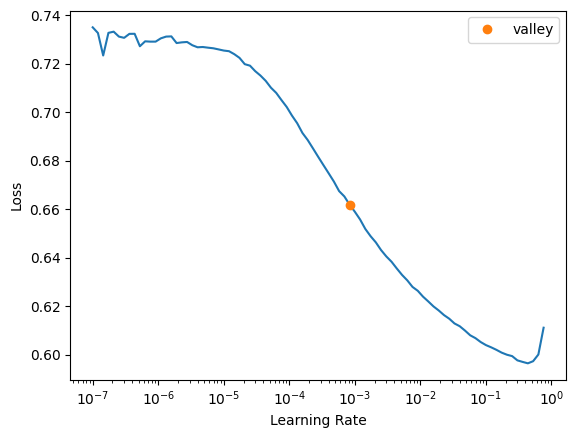

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(n_epoch=3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.515683,0.510313,0.735000,0.808599,00:29
1,0.412188,0.410403,0.805244,0.887624,00:30
2,0.376984,0.370883,0.831404,0.908288,00:30


In [16]:
learn.show_results()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,PY_2,PZ_2,E_3,PX_3,PY_3,PZ_3,E_4,PX_4,PY_4,PZ_4,E_5,PX_5,PY_5,PZ_5,E_6,PX_6,PY_6,PZ_6,E_7,PX_7,PY_7,PZ_7,E_8,PX_8,PY_8,PZ_8,E_9,PX_9,PY_9,PZ_9,E_10,PX_10,PY_10,PZ_10,E_11,PX_11,PY_11,PZ_11,E_12,PX_12,PY_12,PZ_12,E_13,PX_13,PY_13,PZ_13,E_14,PX_14,PY_14,PZ_14,E_15,PX_15,PY_15,PZ_15,E_16,PX_16,PY_16,PZ_16,E_17,PX_17,PY_17,PZ_17,E_18,PX_18,PY_18,PZ_18,E_19,PX_19,PY_19,PZ_19,E_20,PX_20,PY_20,PZ_20,E_21,PX_21,PY_21,PZ_21,E_22,PX_22,PY_22,PZ_22,E_23,PX_23,PY_23,PZ_23,E_24,PX_24,PY_24,PZ_24,E_25,PX_25,PY_25,PZ_25,E_26,PX_26,PY_26,PZ_26,E_27,PX_27,PY_27,PZ_27,E_28,PX_28,PY_28,PZ_28,E_29,PX_29,PY_29,PZ_29,E_30,PX_30,PY_30,PZ_30,E_31,PX_31,PY_31,PZ_31,E_32,PX_32,PY_32,PZ_32,E_33,PX_33,PY_33,PZ_33,E_34,PX_34,PY_34,PZ_34,E_35,PX_35,PY_35,PZ_35,E_36,PX_36,PY_36,PZ_36,E_37,PX_37,PY_37,PZ_37,E_38,PX_38,PY_38,PZ_38,E_39,PX_39,PY_39,PZ_39,E_40,PX_40,PY_40,PZ_40,E_41,PX_41,PY_41,PZ_41,E_42,PX_42,PY_42,PZ_42,E_43,PX_43,PY_43,PZ_43,E_44,PX_44,PY_44,PZ_44,E_45,PX_45,PY_45,PZ_45,E_46,PX_46,PY_46,PZ_46,E_47,PX_47,PY_47,PZ_47,E_48,PX_48,PY_48,PZ_48,E_49,PX_49,PY_49,PZ_49,E_50,PX_50,PY_50,PZ_50,E_51,PX_51,PY_51,PZ_51,E_52,PX_52,PY_52,PZ_52,E_53,PX_53,PY_53,PZ_53,E_54,PX_54,PY_54,PZ_54,E_55,PX_55,PY_55,PZ_55,E_56,PX_56,PY_56,PZ_56,E_57,PX_57,PY_57,PZ_57,E_58,PX_58,PY_58,PZ_58,E_59,PX_59,PY_59,PZ_59,E_60,PX_60,PY_60,PZ_60,E_61,PX_61,PY_61,PZ_61,E_62,PX_62,PY_62,PZ_62,E_63,PX_63,PY_63,PZ_63,E_64,PX_64,PY_64,PZ_64,E_65,PX_65,PY_65,PZ_65,E_66,PX_66,PY_66,PZ_66,E_67,PX_67,PY_67,PZ_67,E_68,PX_68,PY_68,PZ_68,E_69,PX_69,PY_69,PZ_69,E_70,PX_70,PY_70,PZ_70,E_71,PX_71,PY_71,PZ_71,E_72,PX_72,PY_72,PZ_72,E_73,PX_73,PY_73,PZ_73,E_74,PX_74,PY_74,PZ_74,E_75,PX_75,PY_75,PZ_75,E_76,PX_76,PY_76,PZ_76,E_77,PX_77,PY_77,PZ_77,E_78,PX_78,PY_78,PZ_78,E_79,PX_79,PY_79,PZ_79,E_80,PX_80,PY_80,PZ_80,E_81,PX_81,PY_81,PZ_81,E_82,PX_82,PY_82,PZ_82,E_83,PX_83,PY_83,PZ_83,E_84,PX_84,PY_84,PZ_84,E_85,PX_85,PY_85,PZ_85,E_86,PX_86,PY_86,PZ_86,E_87,PX_87,PY_87,PZ_87,E_88,PX_88,PY_88,PZ_88,E_89,PX_89,PY_89,PZ_89,E_90,PX_90,PY_90,PZ_90,E_91,PX_91,PY_91,PZ_91,E_92,PX_92,PY_92,PZ_92,E_93,PX_93,PY_93,PZ_93,E_94,PX_94,PY_94,PZ_94,E_95,PX_95,PY_95,PZ_95,E_96,PX_96,PY_96,PZ_96,E_97,PX_97,PY_97,PZ_97,E_98,PX_98,PY_98,PZ_98,E_99,PX_99,PY_99,PZ_99,E_100,PX_100,PY_100,PZ_100,E_101,PX_101,PY_101,PZ_101,E_102,PX_102,PY_102,PZ_102,E_103,PX_103,PY_103,PZ_103,E_104,PX_104,PY_104,PZ_104,E_105,PX_105,PY_105,PZ_105,E_106,PX_106,PY_106,PZ_106,E_107,PX_107,PY_107,PZ_107,E_108,PX_108,PY_108,PZ_108,E_109,PX_109,PY_109,PZ_109,E_110,PX_110,PY_110,PZ_110,E_111,PX_111,PY_111,PZ_111,E_112,PX_112,PY_112,PZ_112,E_113,PX_113,PY_113,PZ_113,E_114,PX_114,PY_114,PZ_114,E_115,PX_115,PY_115,PZ_115,E_116,PX_116,PY_116,PZ_116,E_117,PX_117,PY_117,PZ_117,E_118,PX_118,PY_118,PZ_118,E_119,PX_119,PY_119,PZ_119,E_120,PX_120,PY_120,PZ_120,E_121,PX_121,PY_121,PZ_121,E_122,PX_122,PY_122,PZ_122,E_123,PX_123,PY_123,PZ_123,E_124,PX_124,PY_124,PZ_124,E_125,PX_125,PY_125,PZ_125,E_126,PX_126,PY_126,PZ_126,E_127,PX_127,PY_127,PZ_127,E_128,PX_128,PY_128,PZ_128,E_129,PX_129,PY_129,PZ_129,E_130,PX_130,PY_130,PZ_130,E_131,PX_131,PY_131,PZ_131,E_132,PX_132,PY_132,PZ_132,E_133,PX_133,PY_133,PZ_133,E_134,PX_134,PY_134,PZ_134,E_135,PX_135,PY_135,PZ_135,E_136,PX_136,PY_136,PZ_136,E_137,PX_137,PY_137,PZ_137,E_138,PX_138,PY_138,PZ_138,E_139,PX_139,PY_139,PZ_139,E_140,PX_140,PY_140,PZ_140,E_141,PX_141,PY_141,PZ_141,E_142,PX_142,PY_142,PZ_142,E_143,PX_143,PY_143,PZ_143,E_144,PX_144,PY_144,PZ_144,E_145,PX_145,PY_145,PZ_145,E_146,PX_146,PY_146,PZ_146,E_147,PX_147,PY_147,PZ_147,E_148,PX_148,PY_148,PZ_148,E_149,PX_149,PY_149,PZ_149,E_150,PX_150,PY_150,PZ_150,E_151,PX_151,PY_151,PZ_151,E_152,PX_152,PY_152,PZ_152,E_153,PX_153,PY_153,PZ_153,E_154,PX_154,PY_154,PZ_154,E_155,PX_155,PY_155,PZ_155,E_156,PX_156,PY_156,PZ_156,E_157,PX_157,PY_157,PZ_157,E_158,PX_158,PY_158,PZ_158,E_159,PX_159,PY_159,PZ_159,E_160,PX_160,PY_160,PZ_160,E_161,PX_161,PY_161,PZ_161,E_162,PX_162,PY_162,PZ_162,E_163,PX_163,PY_163,PZ_163,E_164,PX_16

In [17]:
test_dl = learn.dls.test_dl(test_items=test_df)

In [18]:
preds, targs = learn.get_preds(dl=test_dl)

In [19]:
preds[:5], targs[:5]

(tensor([[0.9971, 0.0029],
         [0.6184, 0.3816],
         [0.9863, 0.0137],
         [0.3935, 0.6065],
         [0.9611, 0.0389]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]], dtype=torch.int8))

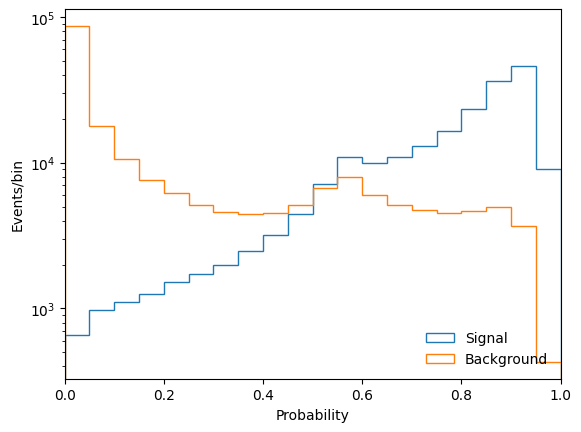

In [20]:
signal_test = preds[:, 1][targs.flatten() == 1].numpy()
background_test = preds[:, 1][targs.flatten() == 0].numpy()

plt.hist(signal_test, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.legend(loc="lower right", frameon=False)
plt.show()

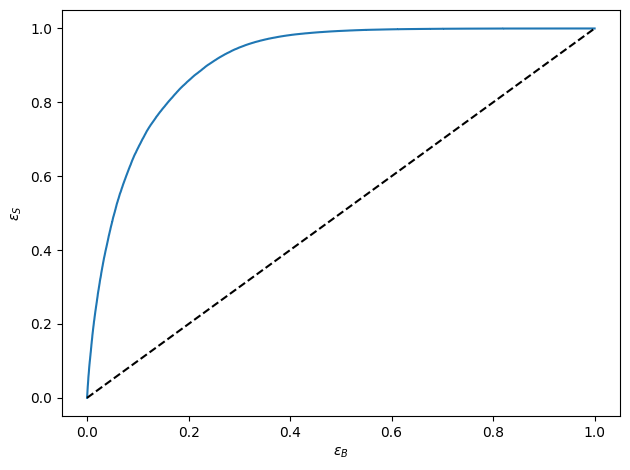

In [21]:
# fpr = epsilon_B, tpr = epsilon_S
fpr, tpr, thresholds = roc_curve(y_true=targs, y_score=preds[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"$\epsilon_B$")
plt.ylabel(r"$\epsilon_S$")
plt.tight_layout()

In [22]:
acc_test = accuracy_score(targs, preds.argmax(dim=-1))
auc_test = auc(fpr, tpr)
print(f"Accuracy: {acc_test:.4f}")
print(f"AUC: {auc_test:.4f}")

Accuracy: 0.8314
AUC: 0.9079


In [23]:
background_eff = interp1d(tpr, fpr)
background_eff_at_30 = background_eff(0.3)
print(f"Backround rejection at signal efficiency 0.3: {1/background_eff_at_30:0.3f}")

Backround rejection at signal efficiency 0.3: 42.517


In [24]:
def compute_metrics(learn, test_df):
    test_dl = learn.dls.test_dl(test_items=test_df)
    preds, targs = learn.get_preds(dl=test_dl)
    fpr, tpr, _ = roc_curve(y_true=targs, y_score=preds[:, 1])
    acc_test = accuracy_score(targs, preds.argmax(dim=-1))
    auc_test = auc(fpr, tpr)
    background_eff = interp1d(tpr, fpr)
    background_eff_at_30 = background_eff(0.3)

    print(f"Accuracy: {acc_test:.4f}")
    print(f"AUC: {auc_test:.4f}")
    print(
        f"Backround rejection at signal efficiency 0.3: {1/background_eff_at_30:0.3f}"
    )
    return fpr, tpr

In [25]:
fpr_baseline, tpr_baseline = compute_metrics(learn, test_df)

Accuracy: 0.8314
AUC: 0.9079
Backround rejection at signal efficiency 0.3: 42.517


In [26]:
def compute_metrics(learn, test_df):
    test_dl = learn.dls.test_dl(test_items=test_df)
    preds, targs = learn.get_preds(dl=test_dl)
    fpr, tpr, _ = roc_curve(y_true=targs, y_score=preds[:, 1])
    acc_test = accuracy_score(targs, preds.argmax(dim=-1))
    auc_test = auc(fpr, tpr)
    background_eff = interp1d(tpr, fpr)
    background_eff_at_30 = background_eff(0.3)

    print(f"Accuracy: {acc_test:.4f}")
    print(f"AUC: {auc_test:.4f}")
    print(
        f"Backround rejection at signal efficiency 0.3: {1/background_eff_at_30:0.3f}"
    )
    return fpr, tpr

In [27]:
fpr_baseline, tpr_baseline = compute_metrics(learn, test_df)

Accuracy: 0.8314
AUC: 0.9079
Backround rejection at signal efficiency 0.3: 42.517


In [28]:
nsubjet_ds = load_dataset("dl4phys/top_tagging_nsubjettiness")

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

C:\Users\Ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ayush\.cache\huggingface\hub\datasets--dl4phys--top_tagging_nsubjettiness. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train.parquet:   0%|          | 0.00/198M [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/69.7M [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/69.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1211000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/403000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/404000 [00:00<?, ? examples/s]

In [29]:
nsubjet_ds.set_format("pandas")
train_df, test_df = nsubjet_ds["train"][:], nsubjet_ds["test"][:]
train_df.head()

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,...,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
0,543.633944,25.846792,0.165122,0.032661,0.002262,0.048830,0.003711,0.000044,0.030994,0.001630,...,0.024336,0.001115,0.000008,0.004252,0.000234,7.706005e-07,0.000000,0.000000,0.000000e+00,0
1,452.411860,13.388679,0.162938,0.027598,0.000876,0.095902,0.015461,0.000506,0.079750,0.009733,...,0.056854,0.005454,0.000072,0.044211,0.004430,6.175314e-05,0.037458,0.003396,3.670517e-05,0
2,429.495258,32.021091,0.244436,0.065901,0.005557,0.155202,0.038807,0.002762,0.123285,0.025339,...,0.078205,0.012678,0.000567,0.052374,0.005935,9.395772e-05,0.037572,0.002932,2.237277e-05,0
3,512.675443,6.684734,0.102580,0.011369,0.000170,0.086306,0.007760,0.000071,0.068169,0.005386,...,0.044705,0.002376,0.000008,0.027895,0.001364,4.400042e-06,0.009012,0.000379,6.731099e-07,0
4,527.956859,133.985415,0.407009,0.191839,0.065169,0.291460,0.105479,0.029753,0.209341,0.049187,...,0.143768,0.033249,0.003689,0.135407,0.029054,2.593460e-03,0.110805,0.023179,2.202088e-03,0


In [30]:
features = list(train_df.drop(columns=["label"]).columns)
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(train_df))

dls = TabularDataLoaders.from_df(
    df=train_df,
    cont_names=features,
    y_names="label",
    y_block=CategoryBlock,
    splits=splits,
    bs=1024,
)

In [31]:
dls.show_batch()

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
0,448.297028,116.264908,0.459055,0.219638,0.066176,0.228401,0.098227,0.030187,0.110271,0.019302,0.000938,0.062046,0.004725,5.613166e-05,0.027745,0.002733,0.000049,0.009126,0.000534,0.000002,1
1,508.935516,35.223183,0.149475,0.034310,0.004797,0.126031,0.023307,0.001656,0.126537,0.021915,0.001510,0.106908,0.017861,1.317987e-03,0.086898,0.013070,0.001031,0.080649,0.010483,0.000593,0
2,555.328674,121.424767,0.323424,0.135594,0.047209,0.165752,0.036642,0.005374,0.095139,0.015626,0.000959,0.080852,0.010741,4.901381e-04,0.064161,0.006960,0.000252,0.059874,0.005589,0.000115,1
3,527.650208,23.470842,0.181214,0.035407,0.001977,0.092318,0.013697,0.001054,0.085889,0.009861,0.000388,0.038265,0.003701,5.012310e-05,0.031920,0.002476,0.000022,0.024606,0.001555,0.000009,0
4,478.918457,46.997234,0.198917,0.054306,0.009664,0.163329,0.038719,0.006394,0.104851,0.014204,0.000456,0.088593,0.010971,3.309961e-04,0.066362,0.007994,0.000270,0.058579,0.005513,0.000068,0
5,437.404175,115.051582,0.461863,0.231200,0.069183,0.313939,0.111696,0.019225,0.252879,0.077069,0.011341,0.185159,0.035976,1.610650e-03,0.149024,0.026484,0.001084,0.126345,0.021260,0.000776,1
6,504.176270,152.331772,0.486870,0.252951,0.089262,0.266398,0.093357,0.031958,0.181698,0.036283,0.001710,0.103341,0.014974,4.123187e-04,0.076779,0.008716,0.000134,0.066699,0.006658,0.000079,1
7,477.439514,56.827087,0.978065,1.939561,11.522518,0.281009,0.082506,0.008155,0.187654,0.041213,0.002437,0.146266,0.027421,1.458872e-03,0.108768,0.016388,0.000624,0.084699,0.010605,0.000329,0
8,546.490845,34.855076,0.241818,0.060187,0.004069,0.041074,0.003161,0.000036,0.021224,0.000784,0.000001,0.005316,0.000122,6.467263e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
9,495.418549,116.892883,0.345179,0.154313,0.054915,0.265516,0.097222,0.029908,0.221406,0.062632,0.014150,0.137816,0.024937,1.459480e-03,0.124229,0.020786,0.000890,0.120437,0.019119,0.000788,1


C:\Users\Ayush\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_loc

SuggestedLRs(valley=0.0008317637839354575)

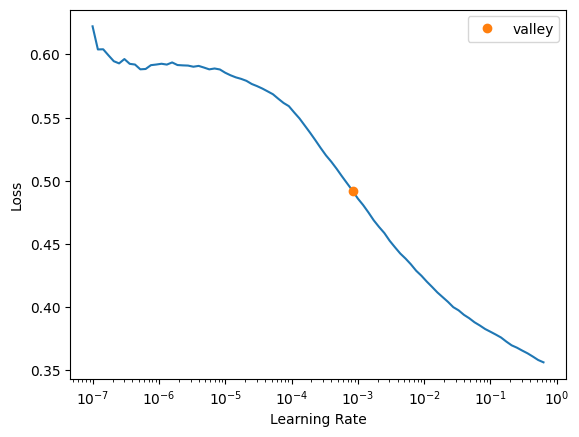

In [32]:
learn = tabular_learner(
    dls, layers=[200, 200, 50, 50], metrics=[accuracy, RocAucBinary()]
)

learn.lr_find()

In [33]:
learn.fit_one_cycle(n_epoch=3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.231959,0.231997,0.901028,0.966566,00:08
1,0.227558,0.223787,0.905268,0.968160,00:08
2,0.224342,0.228141,0.902436,0.967888,00:08


In [34]:
test_df = nsubjet_ds["test"].to_pandas()
fpr_nsubjet, tpr_nsubjet = compute_metrics(learn, test_df)

Accuracy: 0.9017
AUC: 0.9672
Backround rejection at signal efficiency 0.3: 374.609


<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Ayush\AppData\Local\Temp\ipykernel_21332\3413215226.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("Signal befficiency $\epsilon_{S}$")
C:\Users\Ayush\AppData\Local\Temp\ipykernel_21332\3413215226.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("Background rejection $1/\epsilon_{B}$")


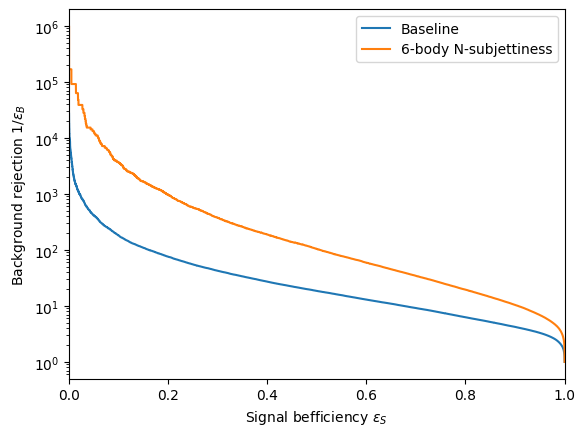

In [35]:
fig, ax = plt.subplots()

plt.plot(tpr_baseline, 1 / (fpr_baseline + 1e-6), label="Baseline")
plt.plot(tpr_nsubjet, 1 / (fpr_nsubjet + 1e-6), label="6-body N-subjettiness")
plt.xlabel("Signal befficiency $\epsilon_{S}$")
plt.ylabel("Background rejection $1/\epsilon_{B}$")
plt.xlim(0, 1)
plt.yscale("log")
plt.legend()
plt.show()

In [36]:
learn.save('N-subjettiness NN model')

Path('models/N-subjettiness NN model.pth')